In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from lightgbm import LGBMClassifier, LGBMRegressor
from collections import Counter

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Data Loading (수술 時 사망 데이터)
data_df=pd.read_csv("https://raw.githubusercontent.com/GonieAhn/Data-Science-online-course-from-gonie/main/Data%20Store/example_data.csv")

In [3]:
data_df.describe()

,censor,event,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,gender,str2,strat,symptom,cd40,cd420,cd496,r,cd80,cd820
count,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,...,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000
mean,0.340226,801.236842,35.225564,76.061855,0.078947,0.640977,0.118421,95.432331,0.030075,0.546992,...,0.812030,0.580827,1.981203,0.167293,353.204887,336.139098,173.146617,0.603383,987.250000,928.214286
std,0.474231,326.887929,8.852094,13.224698,0.269910,0.480165,0.323410,5.981856,0.170955,0.498255,...,0.391056,0.493888,0.905946,0.373589,114.105253,130.961573,191.455406,0.489656,475.223907,438.569798
min,0.000000,33.000000,13.000000,47.401000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,103.000000,49.000000,-1.000000,0.000000,221.000000,150.000000
25%,0.000000,535.750000,29.000000,67.500000,0.000000,0.000000,0.000000,90.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,271.000000,243.750000,-1.000000,0.000000,653.250000,626.500000
50%,0.000000,933.500000,34.000000,74.600000,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,1.000000,2.000000,0.000000,346.000000,330.500000,113.000000,1.000000,881.000000,818.000000
75%,1.000000,1081.000000,40.000000,83.502000,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,1.000000,3.000000,0.000000,422.000000,418.000000,324.000000,1.000000,1190.000000,1164.000000
max,1.000000,1231.000000,70.000000,149.000000,1.000000,1.000000,1.000000,100.000000,1.000000,1.000000,...,1.000000,1.000000,3.000000,1.000000,771.000000,909.000000,857.000000,1.000000,4255.000000,3130.000000


In [4]:
# Data Quality Checking
col = []
missing = []
level = []
for name in data_df.columns:

    # Missing
    missper = data_df[name].isnull().sum() / data_df.shape[0]
    missing.append(round(missper, 4))

    # Leveling
    lel = data_df[name].dropna()
    level.append(len(list(set(lel))))

    # Columns
    col.append(name)

summary = pd.concat([pd.DataFrame(col, columns=['name']),
                     pd.DataFrame(missing, columns=['Missing Percentage']),
                     pd.DataFrame(level, columns=['Level'])], axis=1)

drop_col = summary['name'][(summary['Level'] <= 1) | (summary['Missing Percentage'] >= 0.8)]
data_df.drop(columns=drop_col, inplace=True)
print(">>>> Data Shape : {}".format(data_df.shape))

>>>> Data Shape : (532, 22)


In [5]:
# X's & Y Split
y = data_df['censor']
X = data_df.drop(columns=['censor'])

In [6]:
idx = list(range(X.shape[0]))
train_idx, valid_idx = train_test_split(idx, test_size=0.3, random_state=2021)
print(f">>>> # of Train data : {len(train_idx)}")
print(f">>>> # of valid data : {len(valid_idx)}")
print(f">>>> # of Train data Y : {Counter(y.iloc[train_idx])}")
print(f">>>> # of valid data Y : {Counter(y.iloc[valid_idx])}")

>>>> # of Train data : 372
>>>> # of valid data : 160
>>>> # of Train data Y : Counter({0: 241, 1: 131})
>>>> # of valid data Y : Counter({0: 110, 1: 50})


In [7]:
# n_estimators
n_tree = [5, 10, 20]
# learning_rate
l_rate = [0.1, 0.3]
# max_depth
m_depth = [3, 5]
# reg_alpha
L1_norm = [0.1, 0.3, 0.5]

In [8]:
# Modeling
save_n = []
save_l = []
save_m = []
save_L1 = []
f1_score_ = []

In [9]:
cnt = 0

for n in n_tree:
    for l in l_rate:
        for m in m_depth:
            for L1 in L1_norm:

                print(">>> {} <<<".format(cnt))
                cnt +=1
                print("n_estimators : {}, learning_rate : {}, max_depth : {}, reg_alpha : {}".format(n, l, m, L1))
                model = LGBMClassifier(n_estimators=n, learning_rate=l,
                                       max_depth=m, reg_alpha=L1,
                                       n_jobs=-1, objective='cross_entropy')
                model.fit(X.iloc[train_idx], y.iloc[train_idx])


                # Train Acc
                y_pred_train = model.predict(X.iloc[train_idx])
                cm_train = confusion_matrix(y.iloc[train_idx], y_pred_train)
                print("Train Confusion Matrix")
                print(cm_train)
                print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))
                print("Train F1-Score : {}".format(f1_score(y.iloc[train_idx], y_pred_train)))

                # Test Acc
                y_pred_test = model.predict(X.iloc[valid_idx])
                cm_test = confusion_matrix(y.iloc[valid_idx], y_pred_test)
                print("Test Confusion Matrix")
                print(cm_test)
                print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))
                print("Test F1-Score : {}".format(f1_score(y.iloc[valid_idx], y_pred_test)))
                print("-----------------------------------------------------------------------")
                print("-----------------------------------------------------------------------")
                save_n.append(n)
                save_l.append(l)
                save_m.append(m)
                save_L1.append(L1)
                f1_score_.append(f1_score(y.iloc[valid_idx], y_pred_test))


                #joblib.dump(model, './LightGBM_model/Result_{}_{}_{}_{}_{}.pkl'.format(n, l, m, L1, round(save_acc[-1], 4)))
                #gc.collect()

>>> 0 <<<
n_estimators : 5, learning_rate : 0.1, max_depth : 3, reg_alpha : 0.1
Train Confusion Matrix
[[237   4]
 [ 55  76]]
Train Acc : 0.8413978494623656
Train F1-Score : 0.7203791469194314
Test Confusion Matrix
[[103   7]
 [ 10  40]]
TesT Acc : 0.89375
Test F1-Score : 0.8247422680412372
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 1 <<<
n_estimators : 5, learning_rate : 0.1, max_depth : 3, reg_alpha : 0.3
Train Confusion Matrix
[[237   4]
 [ 54  77]]
Train Acc : 0.8440860215053764
Train F1-Score : 0.7264150943396226
Test Confusion Matrix
[[102   8]
 [ 10  40]]
TesT Acc : 0.8875
Test F1-Score : 0.816326530612245
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 2 <<<
n_estimators : 5, learning_rate : 0.1, max_depth : 3, reg_alpha : 0.5
Train Confusion Matrix
[[237   4]
 [ 54  77]]
Trai

In [10]:
print(f">>> {np.argmax(f1_score_)} <<<")
print(f"Best Test f1-score : {f1_score_[np.argmax(f1_score_)]}")
print(f"Best n_estimators : {save_n[np.argmax(f1_score_)]}")
print(f"Best Learning Rate : {save_l[np.argmax(f1_score_)]}")
print(f"Best Max_depth : {save_m[np.argmax(f1_score_)]}")
print(f"Best L1-norm : {save_L1[np.argmax(f1_score_)]}")

>>> 7 <<<
Best Test f1-score : 0.8672566371681417
Best n_estimators : 5
Best Learning Rate : 0.3
Best Max_depth : 3
Best L1-norm : 0.3


In [11]:
best_model = LGBMClassifier(n_estimators=save_n[np.argmax(f1_score_)], learning_rate=save_l[np.argmax(f1_score_)],
                           max_depth=save_m[np.argmax(f1_score_)], reg_alpha=save_L1[np.argmax(f1_score_)], objective='cross_entropy',
                           random_state=119)
best_model.fit(X.iloc[train_idx], y.iloc[train_idx])

LGBMClassifier(learning_rate=0.3, max_depth=3, n_estimators=5,
               objective='cross_entropy', random_state=119, reg_alpha=0.3)

In [12]:
# Train Acc
y_pre_train = best_model.predict(X.iloc[train_idx])
cm_train = confusion_matrix(y.iloc[train_idx], y_pre_train)
print("Train Confusion Matrix")
print(cm_train)
print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))
print("Train F1-Score : {}".format(f1_score(y.iloc[train_idx], y_pre_train)))

Train Confusion Matrix
[[228  13]
 [ 19 112]]
Train Acc : 0.9139784946236559
Train F1-Score : 0.875


In [13]:
# Test Acc
y_pre_test = best_model.predict(X.iloc[valid_idx])
cm_test = confusion_matrix(y.iloc[valid_idx], y_pre_test)
print("Test Confusion Matrix")
print(cm_test)
print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))
print("Test F1-Score : {}".format(f1_score(y.iloc[valid_idx], y_pre_test)))

Test Confusion Matrix
[[96 14]
 [ 1 49]]
TesT Acc : 0.90625
Test F1-Score : 0.8672566371681417


In [14]:
feature_map = pd.DataFrame(sorted(zip(best_model.feature_importances_, X.columns), reverse=True), columns=['Score', 'Feature'])
print(feature_map)

    Score  Feature
0      10    event
1       4    cd496
2       4    cd420
3       4     cd40
4       3  preanti
5       2     wtkg
6       2     race
7       1      z30
8       1      age
9       0  symptom
10      0    strat
11      0     str2
12      0        r
13      0   oprior
14      0   karnof
15      0     homo
16      0     hemo
17      0   gender
18      0    drugs
19      0    cd820
20      0     cd80


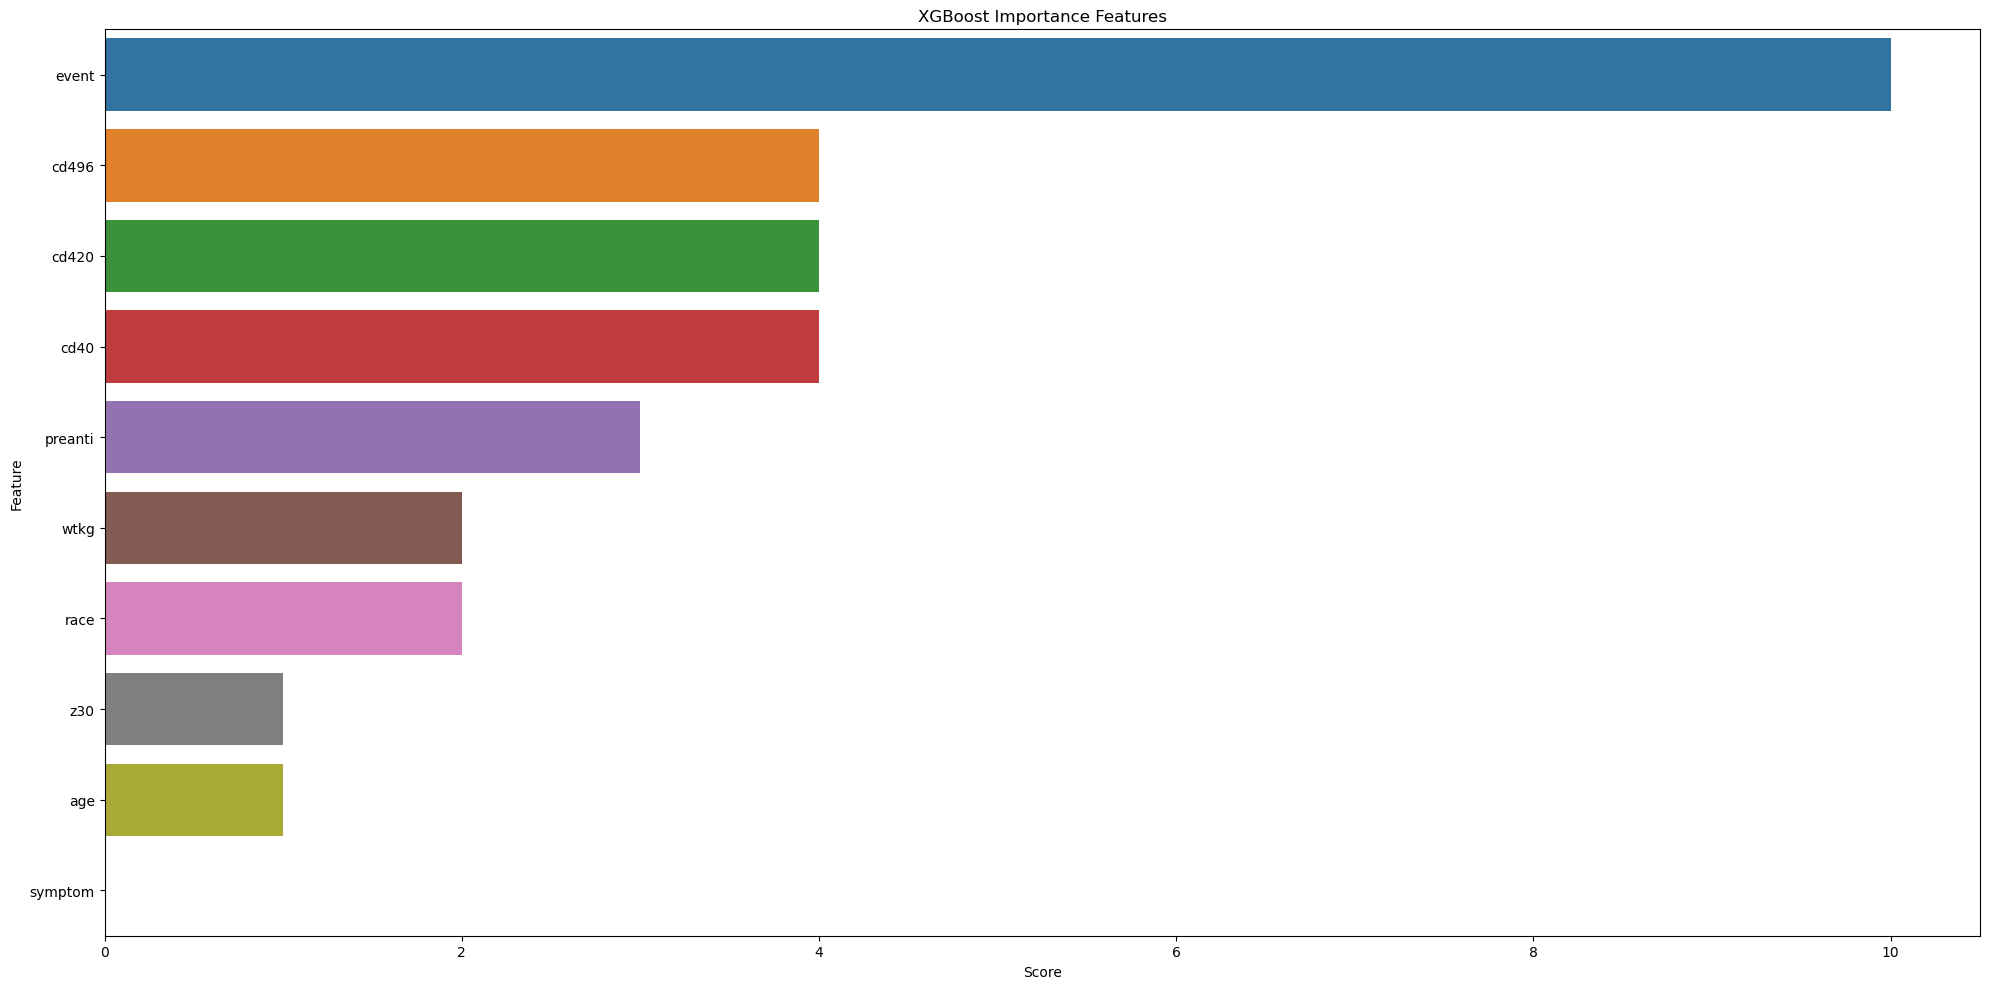

In [15]:
# Importance Score Top 10
feature_map_10 = feature_map.iloc[:10]
plt.figure(figsize=(20, 10))
sns.barplot(x="Score", y="Feature", data=feature_map_10.sort_values(by="Score", ascending=False), errwidth=40)
plt.title('XGBoost Importance Features')
plt.tight_layout()
plt.show()

[SHAPely Values]
  - Package : https://shap.readthedocs.io/en/latest/
  - Package Code & Example : https://github.com/slundberg/shap

[SHAPely Values 내장 함수]
  - force_plot : 특정 데이터 하나 또는 전체 데이터에 대해 Shapley value를 1차원 평면에 정렬하여 보여주는 Plot
  - dependence_plot : 각 특성의 Shapely Value를 확인할 수 있음
    - y축에 나온 특성은 선택한 x와의 관계(상호작용 효과)를 나타냄, 그래프 상에서 색깔이 수직 패턴이 나오는 경우 관계가 존재한다고 판단할 수 잇음
  - Summary_plot : Global하게 Shapely value를 보여주는 plot
    - shapely value 분포에 어떤 영향을 미치는지 시각화 해줌
    - shap_interaction_values : X's 간 관계 (상관관계)를 파악할 수 있는 Plot

[SHAPely Values 주의 사항]
  1. Shapely Values를 계산할 때 시간이 오래걸림
  2. 데이터가 크면 클수록 시간이 많이 걸리기 때문에 원하는 Index만 추출하여 계산하는 것을 추천함
  3. 현재 데이터는 많지 않기 때문에 전체에 대해서 진행할 예정

[TreeExplainer]
  - While SHAP can explain the output of any machine learning model, we have developed a high-speed exact algorithm for tree ensemble methods (see our Nature MI paper). Fast C++ implementations are supported for XGBoost, LightGBM, CatBoost, scikit-learn and pyspark tree models

[GradientExplainer]
  - Expected gradients combines ideas from Integrated Gradients, SHAP, and SmoothGrad into a single expected value equation. This allows an entire dataset to be used as the background distribution (as opposed to a single reference value) and allows local smoothing. If we approximate the model with a linear function between each background data sample and the current input to be explained, and we assume the input features are independent then expected gradients will compute approximate SHAP values. In the example below we have explained how the 7th intermediate layer of the VGG16 ImageNet model impacts the output probabilities.

[KernelExplainer] - 시간 엄청 오래 걸림...
  - Kernel SHAP uses a specially-weighted local linear regression to estimate SHAP values for any model. Below is a simple example for explaining a multi-class SVM on the classic iris dataset.



In [16]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X.iloc[train_idx])

In [19]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1, :], X.iloc[train_idx[1], :], link='logit')

In [20]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X.iloc[train_idx])

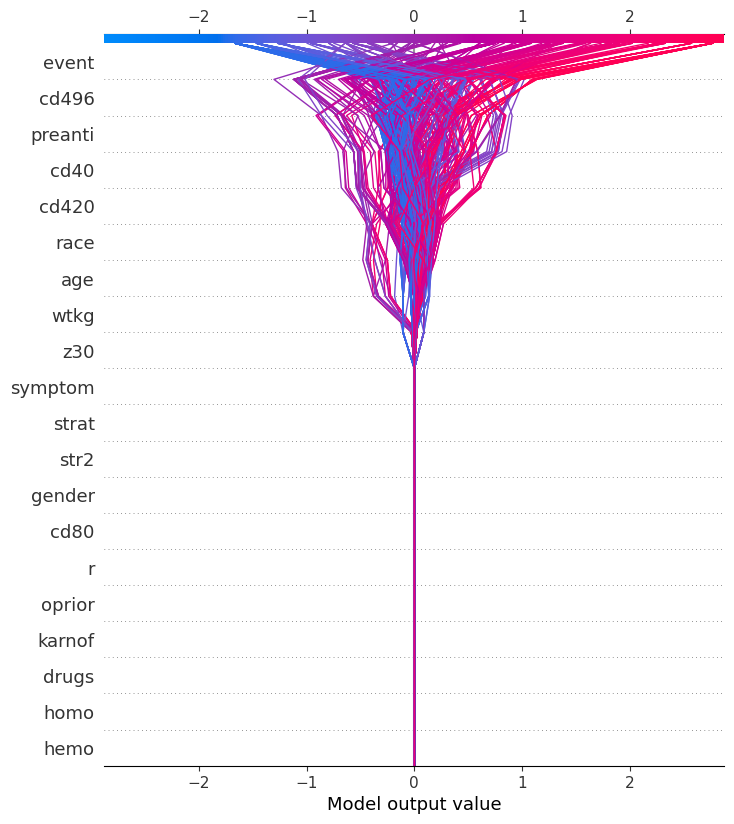

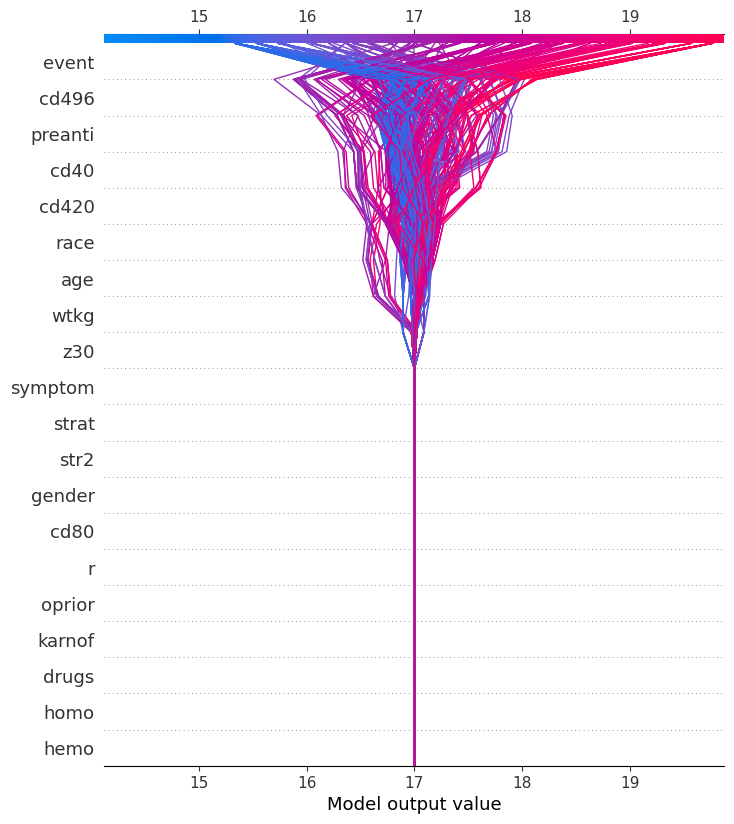

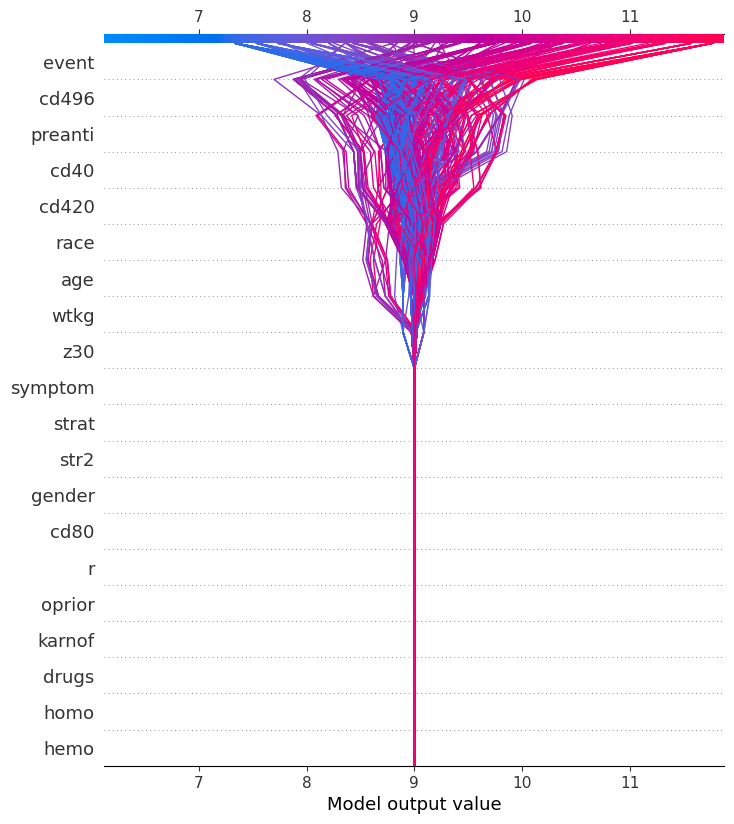

In [21]:
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))
for i in range(3):
    shap.decision_plot(top_inds[i], shap_values, X.iloc[train_idx])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


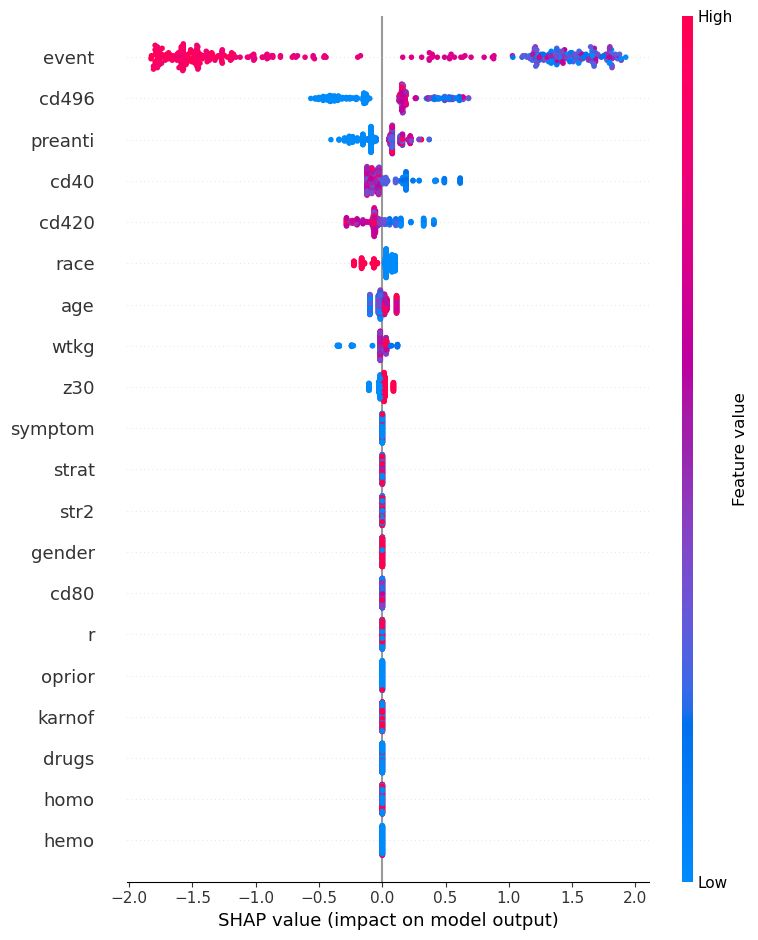

In [23]:
shap.summary_plot(shap_values, X.iloc[train_idx])